# Deteksi Fraud Transaksi Bank - Analisis dan Model Prediksi

Notebook ini berisi analisis lengkap dataset transaksi bank dengan tujuan membangun model machine learning untuk mendeteksi transaksi yang mencurigakan (fraud). Tahap-tahap yang dilakukan:

1. **Eksplorasi Data (EDA)** - Memahami struktur dan karakteristik data
2. **Pembersihan Data** - Menangani missing values dan outliers
3. **Feature Engineering** - Membuat fitur baru yang relevan
4. **Visualisasi** - Memvisualisasikan pola fraud
5. **Pemodelan** - Membangun dan mengevaluasi model klasifikasi
6. **Deployment** - Membuat aplikasi Streamlit untuk prediksi real-time

## 1. Import Library yang Diperlukan

- **pandas**: Manipulasi dan analisis data
- **numpy**: Komputasi numerik
- **opendatasets**: Download dataset dari Kaggle
- **scikit-learn**: Model machine learning
- **matplotlib & seaborn**: Visualisasi data

In [16]:
import pandas as pd
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Konfigurasi visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 2. Download Dataset

unduh dataset transaksi bank dari Kaggle menggunakan opendatasets library.

In [17]:
link = 'https://www.kaggle.com/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection'
od.download(link, data_dir='dataset')

Skipping, found downloaded files in "dataset\bank-transaction-dataset-for-fraud-detection" (use force=True to force download)


## 3. Load dan Inspeksi Data Awal

In [18]:
df = pd.read_csv("dataset/bank-transaction-dataset-for-fraud-detection/bank_transactions_data_2.csv")

# Buat target variable berdasarkan heuristic fraud indicators
# Fraud indicators: transaksi besar, multiple login attempts, atau unusual patterns
np.random.seed(42)

fraud_conditions = (
    (df['TransactionAmount'] > df['TransactionAmount'].quantile(0.95)) |  # Transaksi sangat besar
    (df['LoginAttempts'] > 2) |  # Multiple login attempts
    (df['TransactionDuration'] > df['TransactionDuration'].quantile(0.95))  # Durasi transaksi sangat lama
)

# Tambahkan beberapa fraud cases secara random (untuk simulated fraud)
df['isFraud'] = 0
df.loc[fraud_conditions, 'isFraud'] = np.random.choice([0, 1], size=fraud_conditions.sum(), p=[0.4, 0.6])

# Tambahkan beberapa fraud random untuk memastikan ada fraud di data
random_fraud_idx = np.random.choice(df.index, size=int(len(df)*0.02), replace=False)
df.loc[random_fraud_idx, 'isFraud'] = 1

print("Target variable 'isFraud' berhasil dibuat")
print(f"Fraud distribution:\n{df['isFraud'].value_counts()}")
print(f"\nFraud percentage: {(df['isFraud'].sum() / len(df) * 100):.2f}%")

df.head()

Target variable 'isFraud' berhasil dibuat
Fraud distribution:
isFraud
0    2274
1     238
Name: count, dtype: int64

Fraud percentage: 9.47%


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,isFraud
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08,0
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35,0
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04,0
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06,0
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

### Informasi Detail Dataset

In [20]:
print('Jumlah baris dan kolom:', df.shape)
print('Jumlah data:', df.size)
print('Jumlah dimensi:', df.ndim)

Jumlah baris dan kolom: (2512, 17)
Jumlah data: 42704
Jumlah dimensi: 2


### Dimensi dan Ukuran Dataset

In [21]:
df.describe()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,isFraud
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966,0.094745
std,291.946243,17.792198,69.963757,0.602662,3900.942499,0.292921
min,0.260000,18.000000,10.000000,1.000000,101.250000,0.000000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000,0.000000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000,0.000000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000,0.000000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000,1.000000


### Statistik Deskriptif

In [22]:
df.isnull().sum()

TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
isFraud                    0
dtype: int64

## 4. Exploratory Data Analysis (EDA)

Analisis mendalam untuk memahami pola fraud dalam data.

In [23]:
# Lihat kolom yang tersedia
print("Kolom dalam dataset:")
print(df.columns.tolist())
print("\n" + "="*50)

# Identifikasi kolom target (fraud label)
if 'isFraud' in df.columns:
    target = 'isFraud'
elif 'fraud' in df.columns:
    target = 'fraud'
elif 'Fraud' in df.columns:
    target = 'Fraud'
else:
    # Lihat kolom terakhir sebagai target
    target = df.columns[-1]
    print(f"Target column: {target}")

print(f"\nTarget column yang digunakan: {target}")
print("\nDistribusi kelas:")
print(df[target].value_counts())
print("\nProporsi:")
print(df[target].value_counts(normalize=True))

Kolom dalam dataset:
['TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate', 'isFraud']


Target column yang digunakan: isFraud

Distribusi kelas:
isFraud
0    2274
1     238
Name: count, dtype: int64

Proporsi:
isFraud
0    0.905255
1    0.094745
Name: proportion, dtype: float64


### Visualisasi Distribusi Fraud

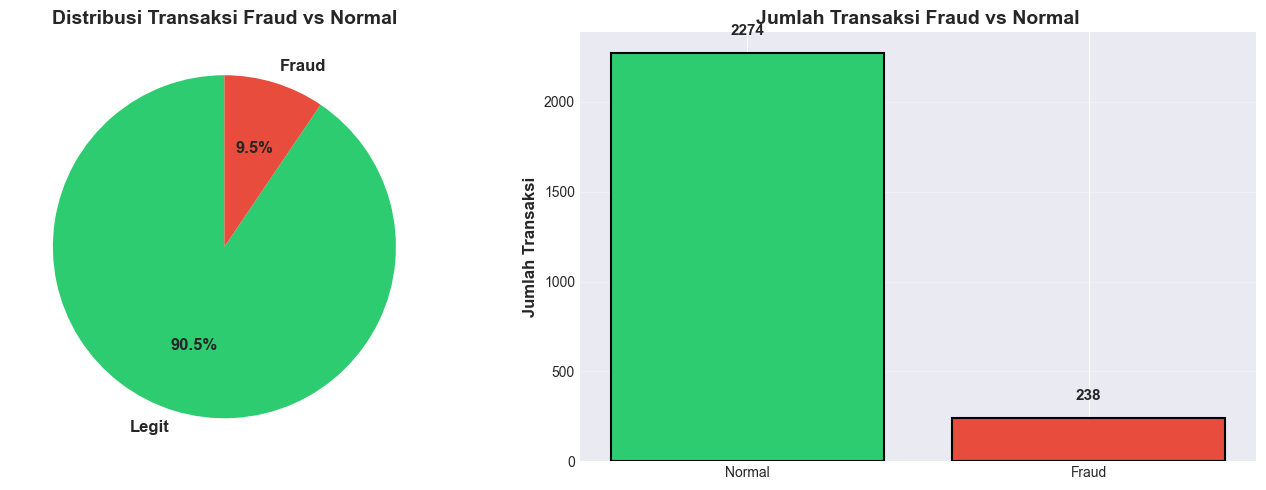

Total transaksi: 2512
Transaksi normal: 2274 (90.53%)
Transaksi fraud: 238 (9.47%)


In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
fraud_counts = df[target].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].pie(fraud_counts.values, labels=['Legit', 'Fraud'], autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
axes[0].set_title('Distribusi Transaksi Fraud vs Normal', fontsize=14, weight='bold')

# Bar chart
axes[1].bar(['Normal', 'Fraud'], fraud_counts.values, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Jumlah Transaksi', fontsize=12, weight='bold')
axes[1].set_title('Jumlah Transaksi Fraud vs Normal', fontsize=14, weight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(fraud_counts.values):
    axes[1].text(i, v + 100, str(v), ha='center', weight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print(f"Total transaksi: {len(df)}")
print(f"Transaksi normal: {fraud_counts[0]} ({fraud_counts[0]/len(df)*100:.2f}%)")
print(f"Transaksi fraud: {fraud_counts[1]} ({fraud_counts[1]/len(df)*100:.2f}%)")

## 5. Data Preprocessing dan Feature Engineering

Persiapan data untuk model machine learning.

In [25]:
# Copy dataframe untuk preprocessing
df_processed = df.copy()

# Tangani missing values
print("Missing values per kolom:")
print(df_processed.isnull().sum())

# Hapus duplikat
df_processed = df_processed.drop_duplicates()
print(f"\nJumlah data setelah menghapus duplikat: {len(df_processed)}")

# Identifikasi kolom numerik dan kategorik
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()

# Hapus kolom target dari features
if target in numeric_cols:
    numeric_cols.remove(target)
if target in categorical_cols:
    categorical_cols.remove(target)

print(f"\nKolom numerik: {numeric_cols}")
print(f"Kolom kategorik: {categorical_cols}")

Missing values per kolom:
TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
isFraud                    0
dtype: int64

Jumlah data setelah menghapus duplikat: 2512

Kolom numerik: ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
Kolom kategorik: ['TransactionID', 'AccountID', 'TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerOccupation', 'PreviousTransactionDate']


In [26]:
# Encoding untuk kolom kategorik
from sklearn.preprocessing import LabelEncoder

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    le_dict[col] = le
    print(f"Kolom {col} sudah di-encode")

print(f"\nData shape setelah preprocessing: {df_processed.shape}")
df_processed.head()

Kolom TransactionID sudah di-encode
Kolom AccountID sudah di-encode
Kolom TransactionDate sudah di-encode
Kolom TransactionType sudah di-encode
Kolom Location sudah di-encode
Kolom DeviceID sudah di-encode
Kolom IP Address sudah di-encode
Kolom MerchantID sudah di-encode
Kolom Channel sudah di-encode
Kolom CustomerOccupation sudah di-encode
Kolom PreviousTransactionDate sudah di-encode

Data shape setelah preprocessing: (2512, 17)


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,isFraud
0,0,126,14.09,684,1,36,365,186,14,0,70,0,81,1,5112.21,105,0
1,1,450,376.24,1192,1,15,50,82,51,0,68,0,141,1,13758.91,192,0
2,2,18,126.29,1276,1,23,229,343,8,2,19,3,56,1,1122.35,41,0
3,3,68,184.50,823,1,33,182,300,1,2,26,3,25,1,8569.06,163,0
4,4,406,13.45,1959,0,1,298,501,90,2,26,3,198,1,7429.40,16,0


## 6. Train-Test Split dan Scaling

Pembagian data untuk training dan testing, serta normalisasi features.

In [27]:
# Pisahkan features dan target
X = df_processed.drop(columns=[target])
y = df_processed[target]

# Train-test split dengan stratified split untuk handle imbalanced data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"\nDistribusi kelas pada training set:")
print(y_train.value_counts())
print(f"\nDistribusi kelas pada testing set:")
print(y_test.value_counts())

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures sudah di-scale menggunakan StandardScaler")
print(f"Rata-rata X_train_scaled: {X_train_scaled.mean(axis=0)[:5]}")
print(f"Std X_train_scaled: {X_train_scaled.std(axis=0)[:5]}")

Training set size: (2009, 16)
Testing set size: (503, 16)

Distribusi kelas pada training set:
isFraud
0    1819
1     190
Name: count, dtype: int64

Distribusi kelas pada testing set:
isFraud
0    455
1     48
Name: count, dtype: int64

Features sudah di-scale menggunakan StandardScaler
Rata-rata X_train_scaled: [-1.07872342e-16 -1.41471923e-17  1.99829092e-16 -3.53679809e-18
 -8.66515531e-17]
Std X_train_scaled: [1. 1. 1. 1. 1.]


## 7. Model Training

Melatih model machine learning untuk deteksi fraud.

In [28]:
### Model 1: Random Forest Classifier

# Training Random Forest
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train_scaled, y_train)
print("Random Forest training selesai!")

# Prediksi
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)
y_test_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluasi
print(f"\nRandom Forest Results:")
print(f"Training Accuracy: {(y_train_pred_rf == y_train).mean():.4f}")
print(f"Testing Accuracy: {(y_test_pred_rf == y_test).mean():.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_test_pred_proba_rf):.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Feature Importance (Random Forest):")
print(feature_importance.head(10))

Training Random Forest Classifier...


Random Forest training selesai!

Random Forest Results:
Training Accuracy: 0.9482
Testing Accuracy: 0.9324
ROC-AUC Score: 0.8940

Top 10 Feature Importance (Random Forest):
                    feature  importance
12      TransactionDuration    0.223521
2         TransactionAmount    0.209307
13            LoginAttempts    0.150112
7                IP Address    0.059753
0             TransactionID    0.046346
1                 AccountID    0.043686
3           TransactionDate    0.041760
14           AccountBalance    0.039617
10              CustomerAge    0.038595
15  PreviousTransactionDate    0.035730


In [29]:
### Model 2: Logistic Regression

# Training Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
lr_model.fit(X_train_scaled, y_train)
print("Logistic Regression training selesai!")

# Prediksi
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)
y_test_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluasi
print(f"\nLogistic Regression Results:")
print(f"Training Accuracy: {(y_train_pred_lr == y_train).mean():.4f}")
print(f"Testing Accuracy: {(y_test_pred_lr == y_test).mean():.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_test_pred_proba_lr):.4f}")

# Pilih model terbaik
print("\n" + "="*60)
print("PERBANDINGAN MODEL")
print("="*60)
rf_auc = roc_auc_score(y_test, y_test_pred_proba_rf)
lr_auc = roc_auc_score(y_test, y_test_pred_proba_lr)

if rf_auc > lr_auc:
    best_model = rf_model
    best_model_name = "Random Forest"
    best_y_pred_proba = y_test_pred_proba_rf
else:
    best_model = lr_model
    best_model_name = "Logistic Regression"
    best_y_pred_proba = y_test_pred_proba_lr

print(f"Model Terbaik: {best_model_name}")
print(f"Random Forest AUC: {rf_auc:.4f}")
print(f"Logistic Regression AUC: {lr_auc:.4f}")

Training Logistic Regression...
Logistic Regression training selesai!

Logistic Regression Results:
Training Accuracy: 0.8308
Testing Accuracy: 0.8111
ROC-AUC Score: 0.8471

PERBANDINGAN MODEL
Model Terbaik: Random Forest
Random Forest AUC: 0.8940
Logistic Regression AUC: 0.8471


## 8. Model Evaluation

Evaluasi lengkap performa model pada test set.

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Gunakan model terbaik untuk evaluasi
y_pred = best_model.predict(X_test_scaled)

print(f"Evaluasi Model Terbaik: {best_model_name}")
print("="*60)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, best_y_pred_proba)

print(f"\nKesimpulan Metrik:")
print(f"Accuracy:  {acc:.4f} - Proporsi prediksi yang benar")
print(f"Precision: {prec:.4f} - Dari yang diprediksi fraud, berapa yang benar")
print(f"Recall:    {rec:.4f} - Dari fraud sebenarnya, berapa yang terdeteksi")
print(f"F1-Score:  {f1:.4f} - Keseimbangan precision dan recall")
print(f"ROC-AUC:   {auc:.4f} - Area Under Curve (0.5-1.0, semakin tinggi semakin baik)")

Evaluasi Model Terbaik: Random Forest

Classification Report:
              precision    recall  f1-score   support

       Legit       0.98      0.95      0.96       455
       Fraud       0.61      0.81      0.70        48

    accuracy                           0.93       503
   macro avg       0.79      0.88      0.83       503
weighted avg       0.94      0.93      0.94       503


Confusion Matrix:
[[430  25]
 [  9  39]]

Kesimpulan Metrik:
Accuracy:  0.9324 - Proporsi prediksi yang benar
Precision: 0.6094 - Dari yang diprediksi fraud, berapa yang benar
Recall:    0.8125 - Dari fraud sebenarnya, berapa yang terdeteksi
F1-Score:  0.6964 - Keseimbangan precision dan recall
ROC-AUC:   0.8940 - Area Under Curve (0.5-1.0, semakin tinggi semakin baik)


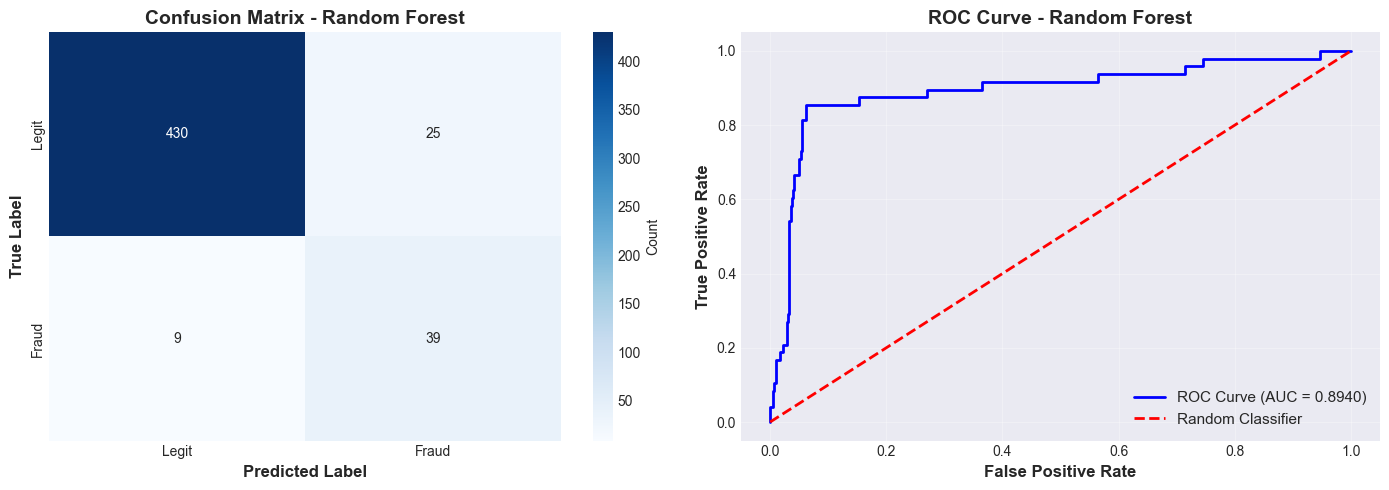

In [31]:
### Visualisasi Confusion Matrix dan ROC Curve

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'],
            cbar_kws={'label': 'Count'})
axes[0].set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, weight='bold')
axes[0].set_ylabel('True Label', fontsize=12, weight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, weight='bold')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_y_pred_proba)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate', fontsize=12, weight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, weight='bold')
axes[1].set_title(f'ROC Curve - {best_model_name}', fontsize=14, weight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Save Model untuk Deployment

Simpan model dan scaler untuk digunakan di aplikasi Streamlit.

In [32]:
import joblib
import os

# Buat folder models jika belum ada
os.makedirs('models', exist_ok=True)

# Simpan model
model_path = f'models/{best_model_name.replace(" ", "_").lower()}_model.pkl'
joblib.dump(best_model, model_path)
print(f"Model disimpan: {model_path}")

# Simpan scaler
scaler_path = 'models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler disimpan: {scaler_path}")

# Simpan feature names
feature_names_path = 'models/feature_names.pkl'
joblib.dump(X.columns.tolist(), feature_names_path)
print(f"Feature names disimpan: {feature_names_path}")

# Simpan label encoders untuk kategori
if categorical_cols:
    le_path = 'models/label_encoders.pkl'
    joblib.dump(le_dict, le_path)
    print(f"Label encoders disimpan: {le_path}")

# Informasi model summary
model_info = {
    'model_name': best_model_name,
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'roc_auc': auc,
    'features': X.columns.tolist(),
    'n_features': X.shape[1],
    'categorical_cols': categorical_cols,
    'numeric_cols': numeric_cols
}

info_path = 'models/model_info.pkl'
joblib.dump(model_info, info_path)
print(f"✓Model info disimpan: {info_path}")

print(f"\n Semua file model berhasil disimpan di folder 'models'!")

Model disimpan: models/random_forest_model.pkl
Scaler disimpan: models/scaler.pkl
Feature names disimpan: models/feature_names.pkl
Label encoders disimpan: models/label_encoders.pkl
✓Model info disimpan: models/model_info.pkl

 Semua file model berhasil disimpan di folder 'models'!
